# SWB Regression Pipeline - HFA Power 
Created: 07/30/24 \
Updated: 08/22/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08222024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [7]:
band = 'hfa' 
hfa_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
hfa_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [10]:
# #### filter df by rois with electrode counts >= 50 *** updated to >15
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
# ).values>=20].tolist()

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
    roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
# keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','hpc','amy','mtg']     
keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [12]:
# ####### NEW DATA FRAME 
hfa_reg_df = hfa_df.copy()
hfa_reg_df = hfa_reg_df[hfa_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [13]:
elec_col    = 'unique_reref_ch'
main_var    = 'decisionCPE'
reg_formula = 'band_pow~GambleChoice+TotalProfit+decisionCPE'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(hfa_reg_df,reg_formula,elec_col, main_var,n_permutations)

Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2910.65it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2953.44it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2730.08it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3324.47it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3223.61it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3238.99it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3191.05it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2932.36it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3020.93it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3183.29it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2930.55it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3205.90it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2804.14it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3133.81it/s]


In [14]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'decisionCPE']

In [15]:
results = single_elec_permutation_results(results_dict,hfa_reg_df,save_vars)
results

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.003846,-0.000088,...,0.010525,0.010402,1.671885,-1.671885,-2.389636,2.006046,0.094547,0.094547,0.016865,0.044851
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004812,-0.000020,...,0.012472,0.012430,1.958110,-1.958110,-1.629926,2.582337,0.050217,0.050217,0.103117,0.009813
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.002761,0.000086,...,0.012274,0.013415,2.131416,-2.131416,-2.736019,-0.012631,0.033055,0.033055,0.006219,0.989922
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,-0.000148,0.000437,...,0.014513,0.014216,1.564414,-1.564414,-2.729727,0.062135,0.117720,0.117720,0.006339,0.950455
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.002992,0.000911,...,0.012655,0.012204,2.203852,-2.203852,-0.683431,-0.277356,0.027535,0.027535,0.494334,0.781507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DA039_rpins6-rpins7,DA039,stg,22,0.004782,-0.042341,0.044020,-0.055510,-0.011494,0.000117,...,0.041439,0.041737,1.056946,-1.056946,1.082668,-1.325001,0.290536,0.290536,0.278956,0.185171
1616,DA039_rpins7-rpins8,DA039,stg,22,0.004178,-0.027140,0.042991,-0.057898,-0.006236,0.000026,...,0.034435,0.034346,0.763018,-0.763018,1.231774,-1.686184,0.445453,0.445453,0.218034,0.091760
1617,DA039_rpins8-rpins9,DA039,stg,22,0.008739,-0.020844,0.022332,-0.054699,0.000329,0.001095,...,0.041673,0.043313,0.523122,-0.523122,0.562666,-1.269165,0.600889,0.600889,0.573662,0.204382
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080892,0.000634,...,0.021640,0.021740,-1.814524,1.814524,1.243150,1.252406,0.069597,0.069597,0.213813,0.210422


In [16]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))

In [17]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.003846,-0.000088,...,0.010525,0.010402,1.671885,-1.671885,-2.389636,2.006046,0.094547,0.094547,0.016865,0.044851
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004812,-0.000020,...,0.012472,0.012430,1.958110,-1.958110,-1.629926,2.582337,0.050217,0.050217,0.103117,0.009813
47,MS002_lpips3-lpips4,MS002,pins,14,0.015306,-0.032655,-0.033791,-0.044934,-0.008108,0.001191,...,0.020524,0.020352,1.508538,-1.508538,-1.660144,-2.207322,0.131417,0.131417,0.096885,0.027292
58,MS002_racas6-racas7,MS002,dmpfc,14,0.021060,-0.002760,-0.027003,-0.028567,0.019359,-0.000302,...,0.013754,0.014526,0.163729,-0.163729,-1.927588,-1.974743,0.869944,0.869944,0.053906,0.048297
59,MS002_racas7-racas8,MS002,dmpfc,14,0.023569,-0.002962,-0.018571,-0.031314,0.021654,-0.000193,...,0.015337,0.014517,0.182268,-0.182268,-1.242353,-2.165967,0.855373,0.855373,0.214106,0.030314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1554,DA037_rsmg15-rsmg16,DA037,smg,4,-0.001303,0.012758,0.027633,-0.032089,0.001583,0.000491,...,0.015552,0.014480,-0.691790,0.691790,1.811281,-2.196700,0.489069,0.489069,0.070097,0.028042
1565,DA037_rof1-rof2,DA037,ofc,4,-0.012610,0.001246,0.034839,0.060822,-0.012278,-0.000162,...,0.024357,0.023786,-0.050273,0.050273,1.457521,2.526703,0.959905,0.959905,0.144973,0.011514
1572,DA037_rmc7-rmc8,DA037,dlpfc,4,-0.026976,0.074267,0.029557,-0.061234,-0.009537,0.000150,...,0.020327,0.020189,-3.176596,3.176596,1.454053,-3.071975,0.001490,0.001490,0.145931,0.002126
1584,DA039_rains4-rains5,DA039,ains,22,0.010382,0.005051,-0.010391,0.027364,0.012216,0.000268,...,0.014870,0.014179,-0.328739,0.328739,-0.674063,1.962239,0.742353,0.742353,0.500272,0.049735


In [18]:
sig_data.roi.value_counts()

acc         32
ofc         23
dmpfc       17
ains        15
smg         12
vlpfc       10
hpc          9
sts          9
dlpfc        8
amy          8
stg          6
pins         4
thalamus     4
mtg          3
Name: roi, dtype: int64

In [19]:
sig_data.roi.unique()

array(['acc', 'pins', 'dmpfc', 'mtg', 'ains', 'ofc', 'vlpfc', 'stg',
       'sts', 'amy', 'dlpfc', 'hpc', 'thalamus', 'smg'], dtype=object)

In [20]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


In [21]:
results.groupby('roi').agg('mean')['Z_Score_decisionCPE'][bar_order]

roi
dlpfc   -0.097386
vlpfc    0.178292
dmpfc    0.092586
ofc      0.574653
ains     0.224954
pins     0.146404
acc      0.472798
hpc      0.171977
amy      0.400060
Name: Z_Score_decisionCPE, dtype: float64

In [22]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res

,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_decisionCPE,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_decisionCPE,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_decisionCPE,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_decisionCPE
0,MS002_lacas1-lacas2,MS002,acc,14,0.009602,-0.019527,-0.024831,0.021213,-0.003846,-0.000088,...,0.010525,0.010402,1.671885,-1.671885,-2.389636,2.006046,0.094547,0.094547,0.016865,0.044851
1,MS002_lacas2-lacas3,MS002,acc,14,0.013824,-0.026959,-0.020466,0.032208,-0.004812,-0.000020,...,0.012472,0.012430,1.958110,-1.958110,-1.629926,2.582337,0.050217,0.050217,0.103117,0.009813
2,MS002_lacas3-lacas4,MS002,acc,14,0.018103,-0.030073,-0.034169,0.000575,-0.002761,0.000086,...,0.012274,0.013415,2.131416,-2.131416,-2.736019,-0.012631,0.033055,0.033055,0.006219,0.989922
3,MS002_lacas4-lacas5,MS002,acc,14,0.015891,-0.022747,-0.039756,0.001034,-0.000148,0.000437,...,0.014513,0.014216,1.564414,-1.564414,-2.729727,0.062135,0.117720,0.117720,0.006339,0.950455
4,MS002_lacas5-lacas6,MS002,acc,14,0.023452,-0.028664,-0.008658,-0.003695,0.002992,0.000911,...,0.012655,0.012204,2.203852,-2.203852,-0.683431,-0.277356,0.027535,0.027535,0.494334,0.781507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1610,DA039_rpins1-rpins2,DA039,pins,22,-0.000885,-0.018211,0.018350,0.001634,-0.007888,0.000056,...,0.017630,0.017046,1.041085,-1.041085,1.003289,0.089367,0.297836,0.297836,0.315722,0.928790
1611,DA039_rpins2-rpins3,DA039,pins,22,-0.000429,-0.038045,0.028140,-0.020577,-0.014928,-0.000219,...,0.025414,0.026518,1.460050,-1.460050,1.099217,-0.739390,0.144276,0.144276,0.271674,0.459670
1612,DA039_rpins3-rpins4,DA039,pins,22,0.001596,-0.051768,0.039688,-0.042583,-0.018812,0.001471,...,0.038675,0.038410,1.389073,-1.389073,1.041232,-1.100424,0.164810,0.164810,0.297768,0.271148
1618,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.096861,0.042294,0.026198,0.028030,-0.080892,0.000634,...,0.021640,0.021740,-1.814524,1.814524,1.243150,1.252406,0.069597,0.069597,0.213813,0.210422


In [23]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)

In [24]:
agg_single_results = single_elec_res.groupby('roi').agg('mean')[['Z_Score_decisionCPE']].copy()

agg_single_results


,Z_Score_decisionCPE
roi,
acc,0.472798
ains,0.224954
amy,0.400060
dlpfc,-0.097386
dmpfc,0.092586
hpc,0.171977
ofc,0.574653
pins,0.146404
vlpfc,0.178292


In [25]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_decisionCPE'] = agg_single_results.Z_Score_decisionCPE
single_rho_data[['Z_Score_decisionCPE','rho','rho_p']]

,Z_Score_decisionCPE,rho,rho_p
roi,,,
acc,0.472798,-0.163559,0.0230
dmpfc,0.092586,-0.139156,0.0410
amy,0.400060,-0.288883,0.0019
ains,0.224954,-0.211214,0.0770
vlpfc,0.178292,-0.034522,0.7582
hpc,0.171977,-0.151291,0.0798
ofc,0.574653,0.047199,0.5048
pins,0.146404,-0.069193,0.5994
dlpfc,-0.097386,-0.035281,0.7183


In [26]:
ylabel = fr'$HFA_{{zpow}} \sim cpe$'
fig_save_dir = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/results/single-electrode-regressions/'
fig_id = f'{band}_single_elec_roi_barplot.pdf'


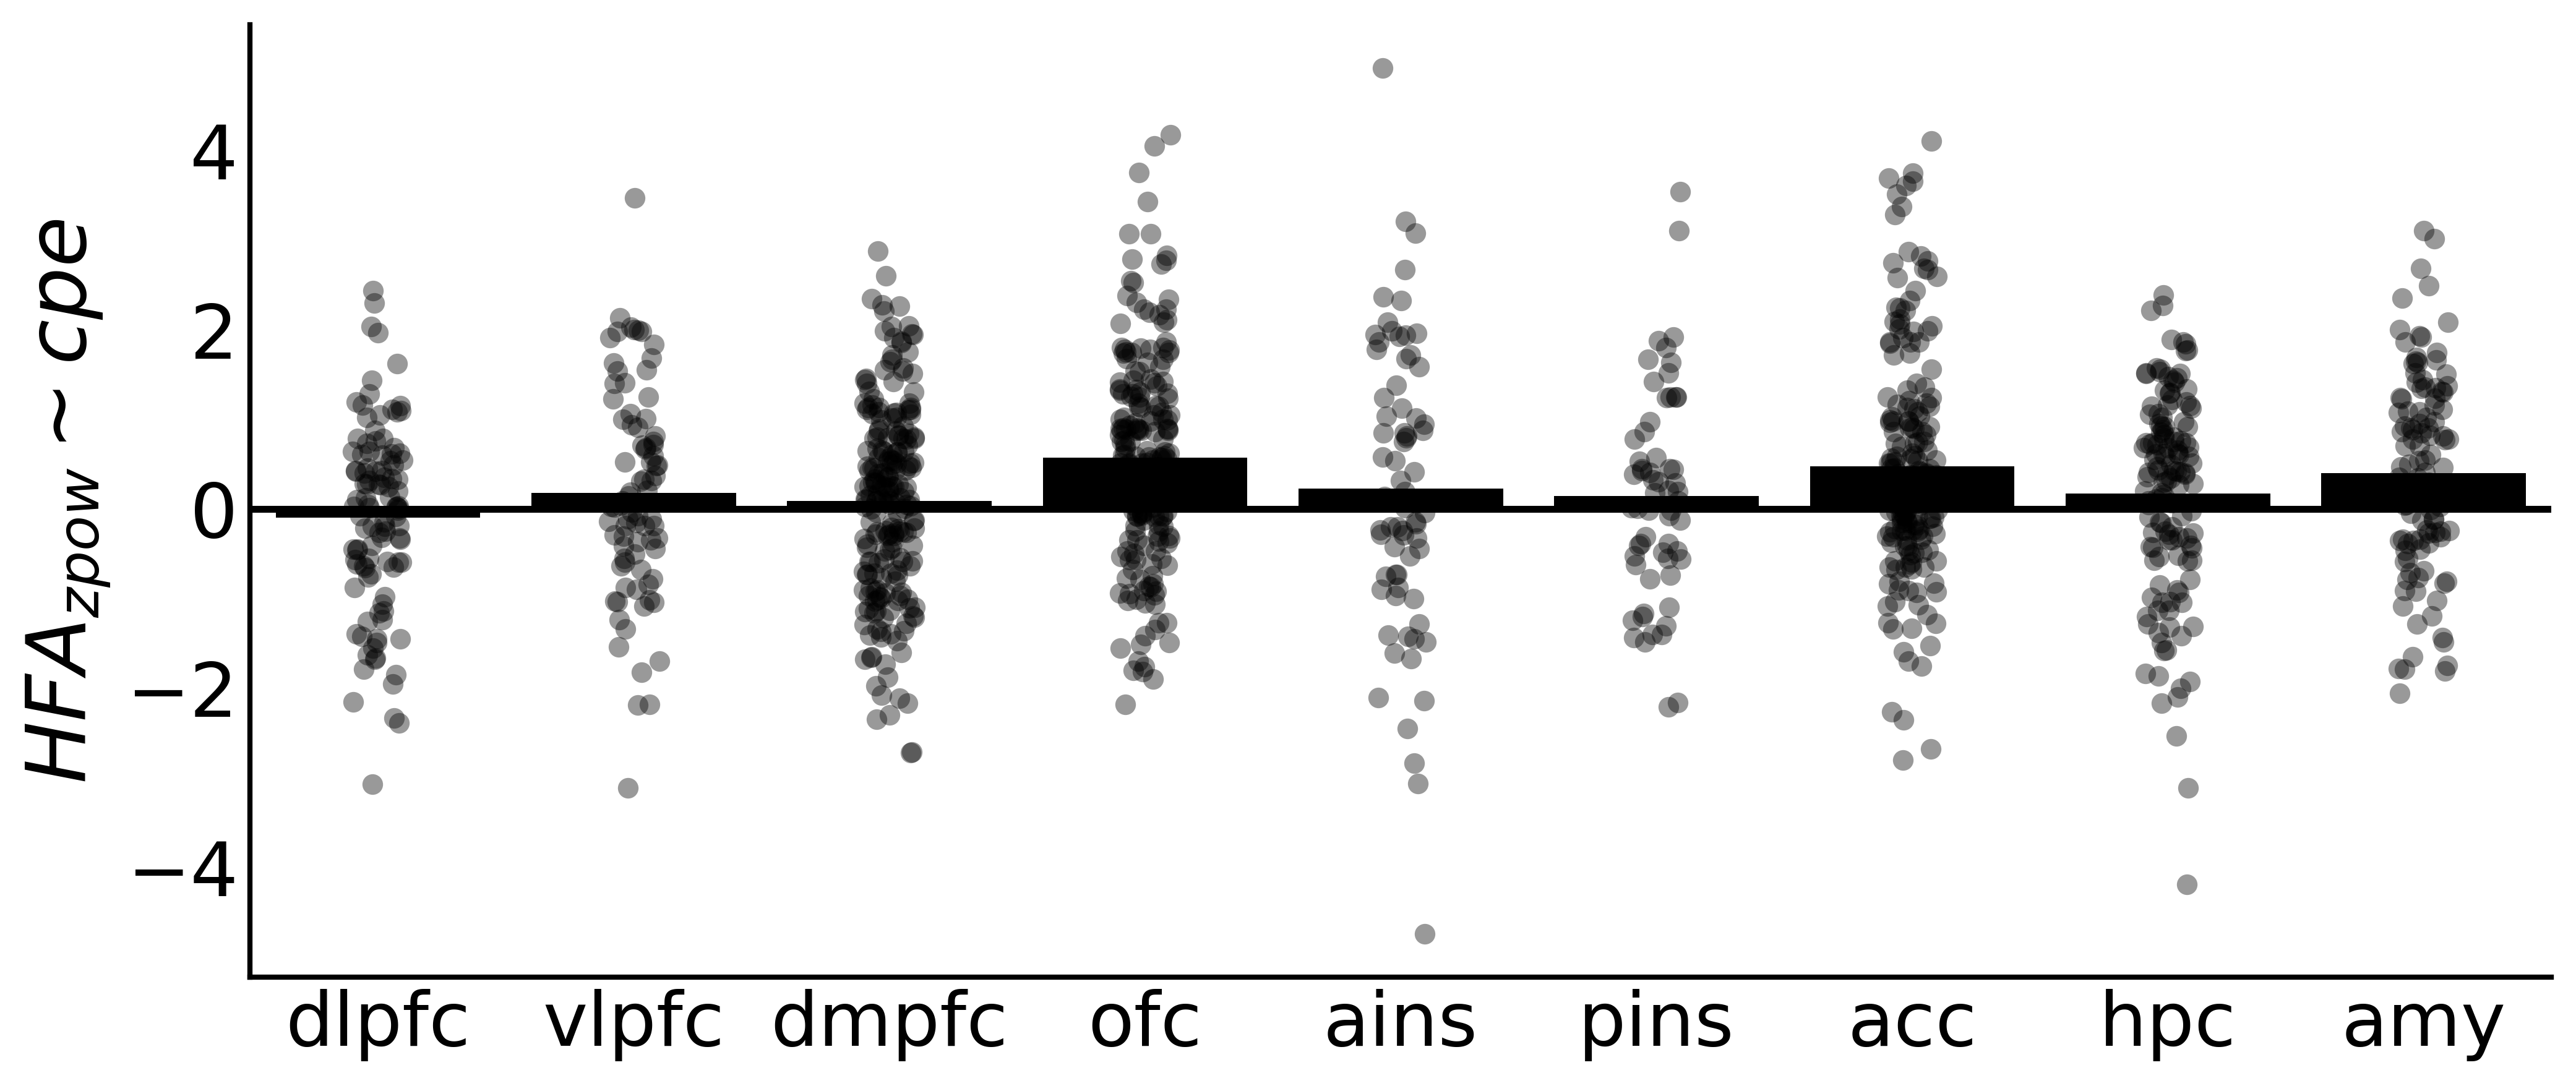

In [27]:
plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_dir,fig_id=fig_id,dpi=400)


In [28]:
results.to_csv(f'{fig_save_dir}{band}_single_elec_perm_results.csv')

In [35]:
# plot_roi_model_results(results,'roi','Z_Score_decisionCPE',bar_order=bar_order,figsize=(13,4),color='k')
# green '#135546'


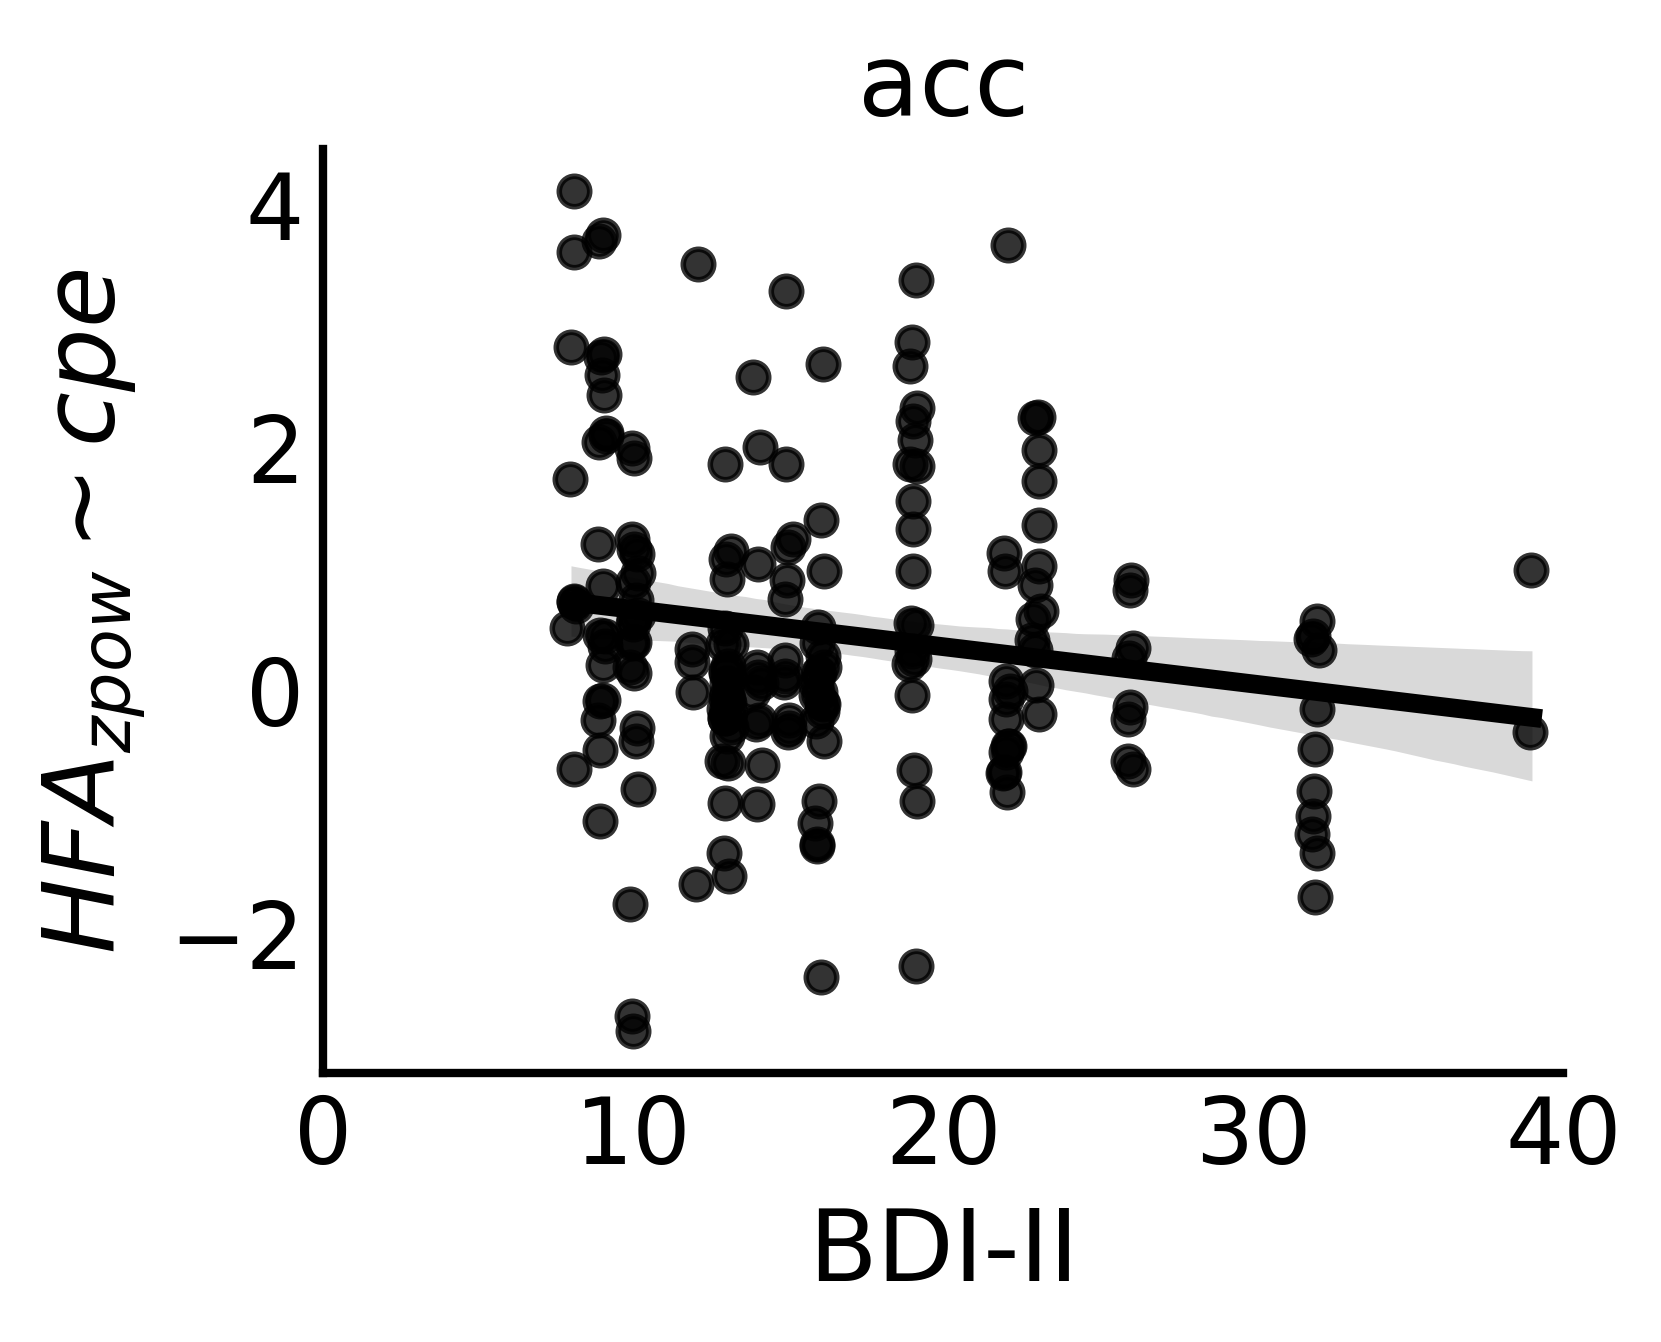

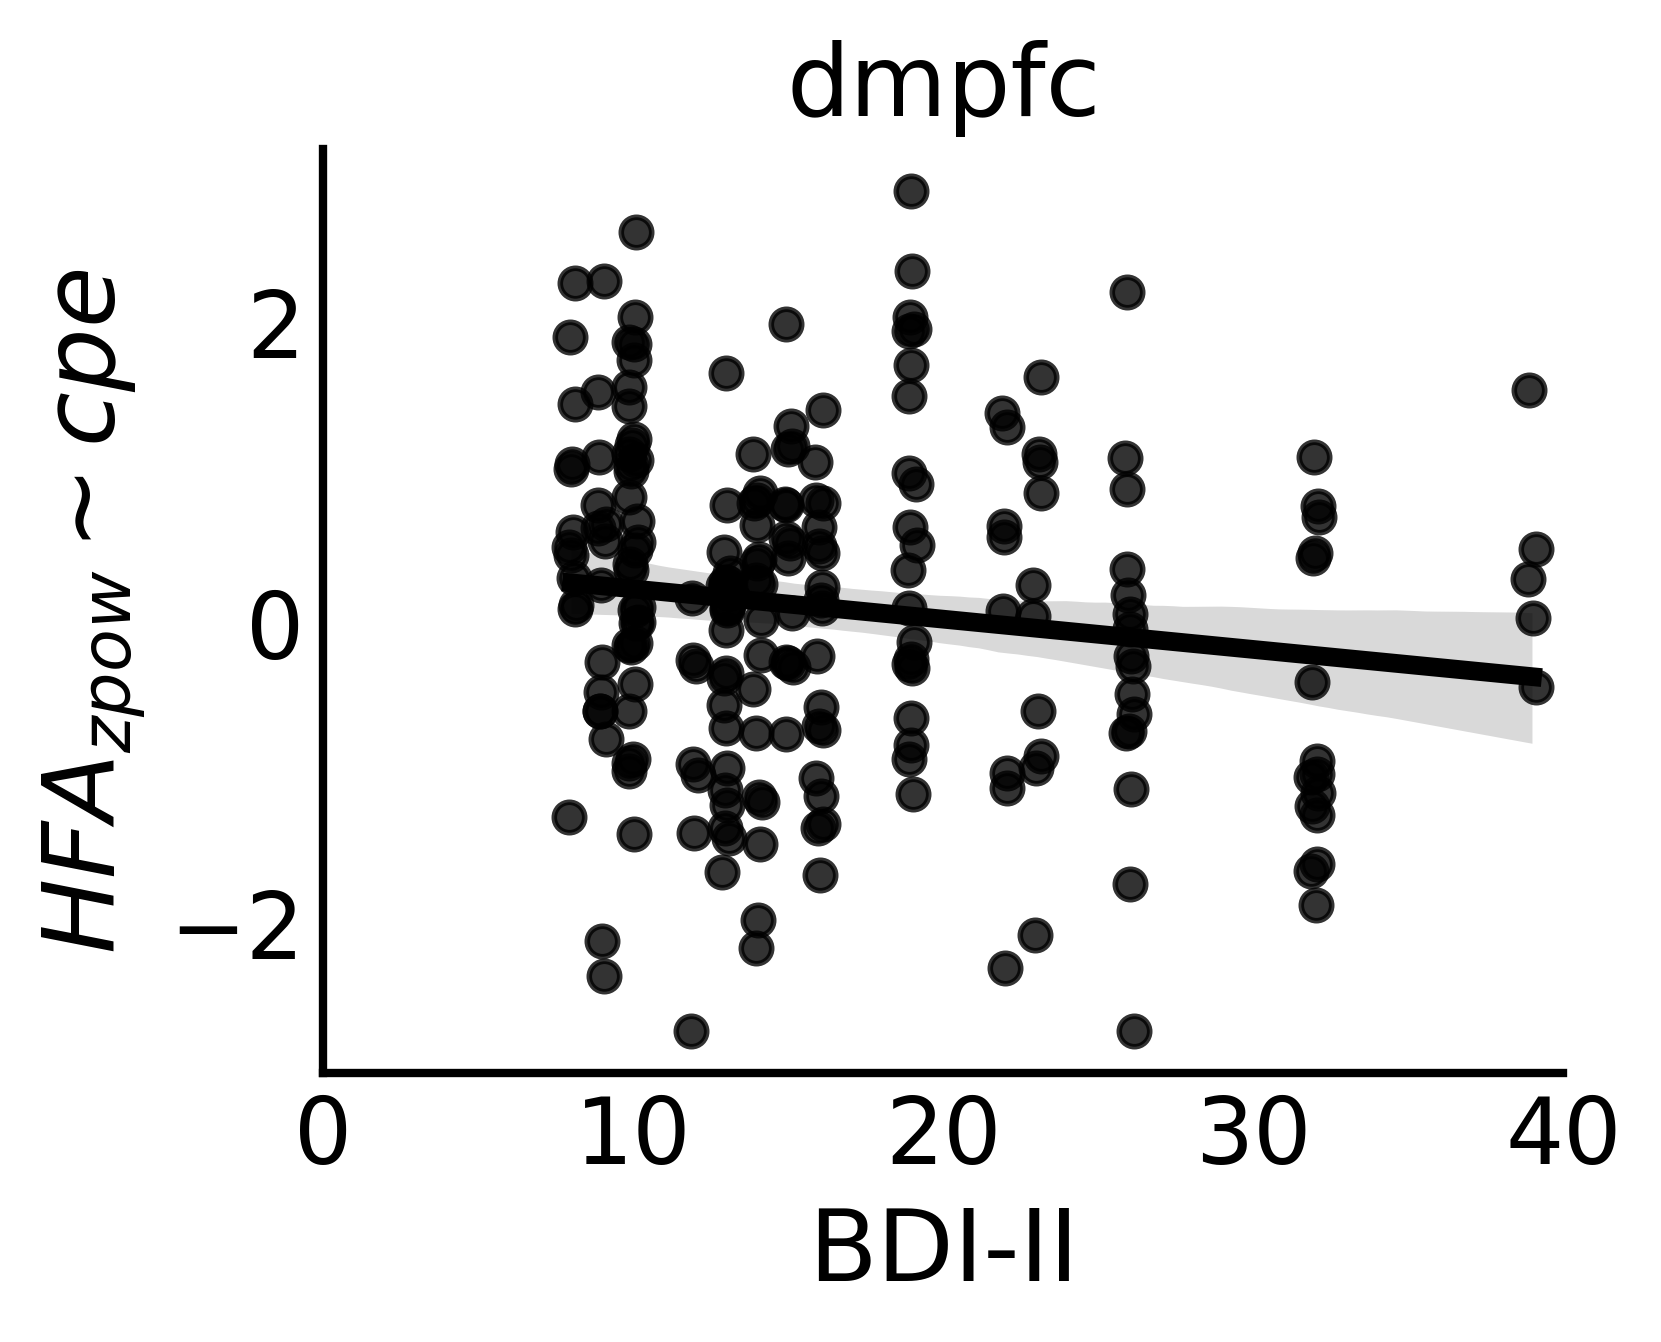

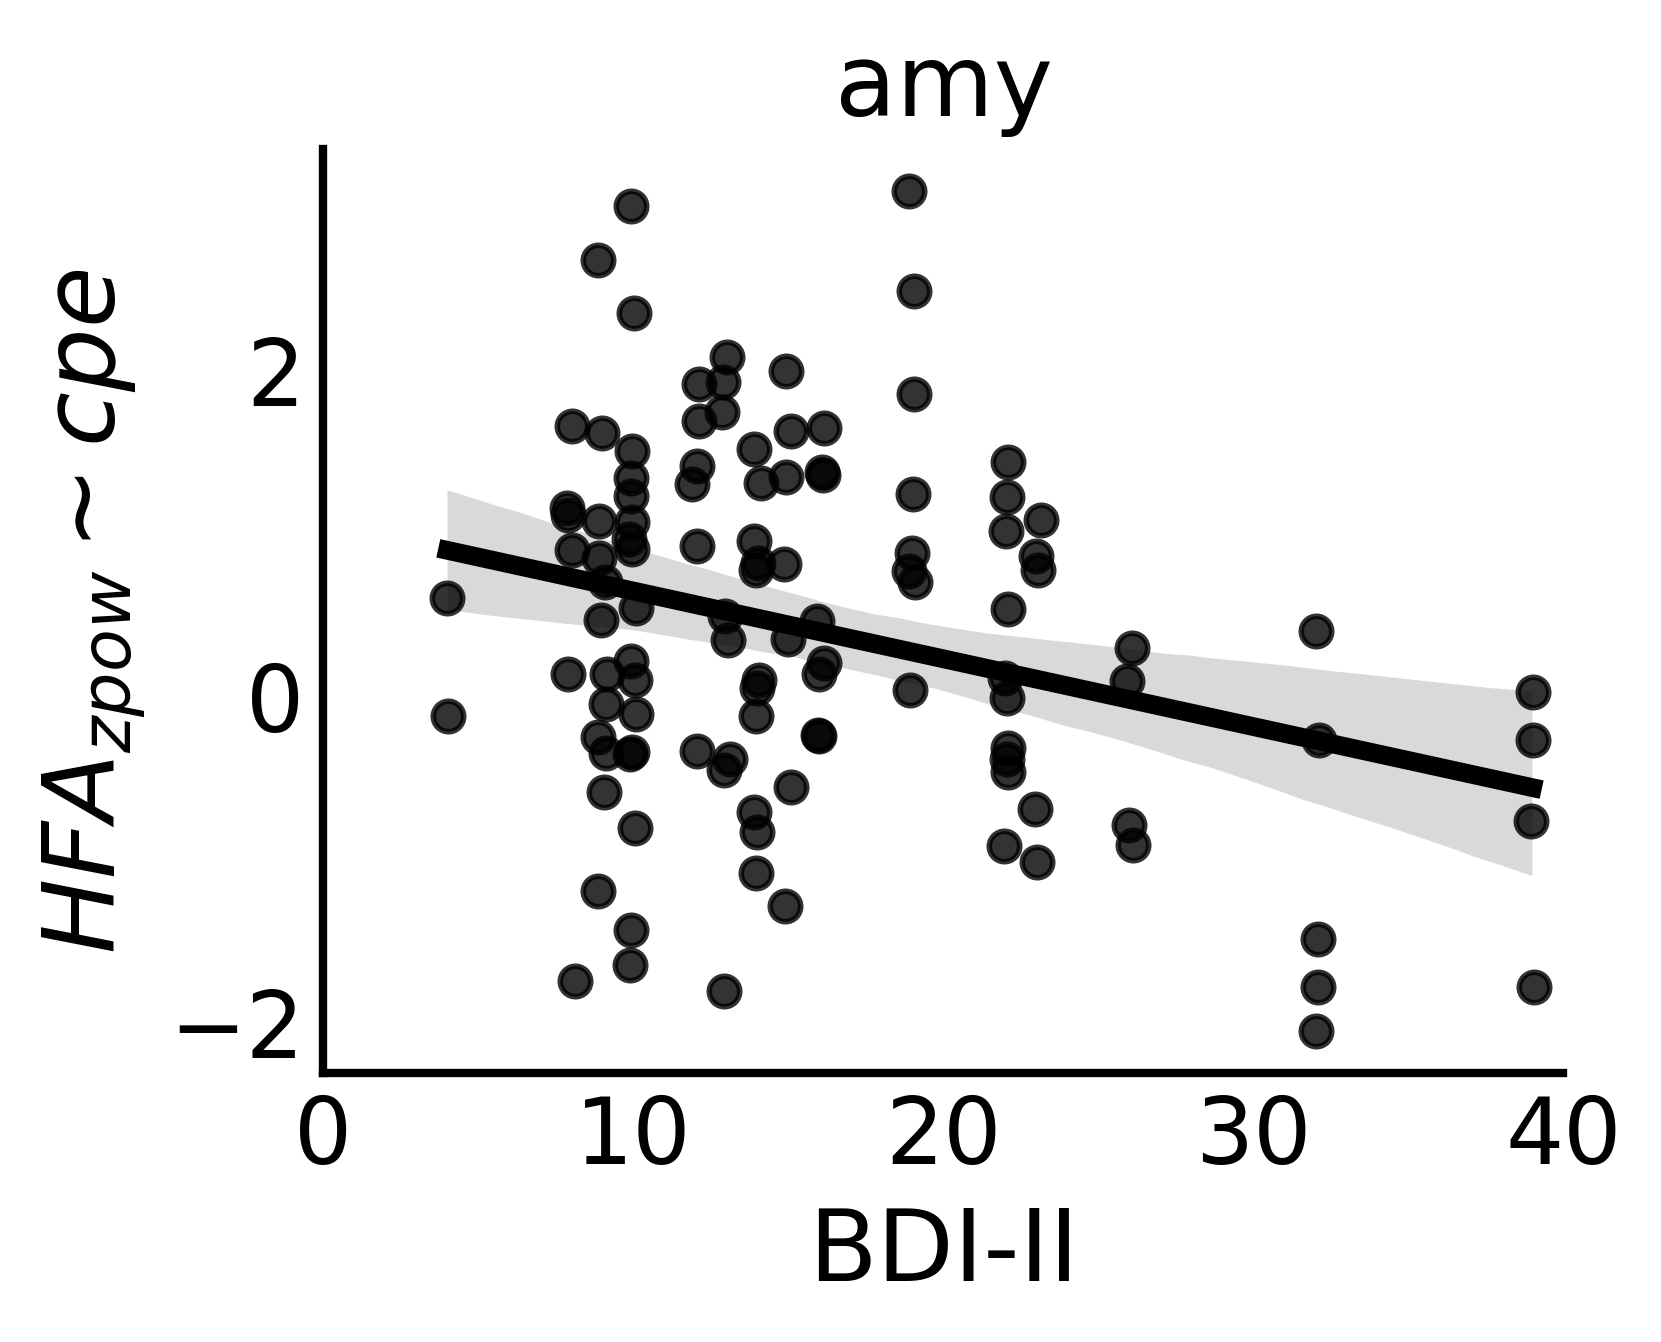

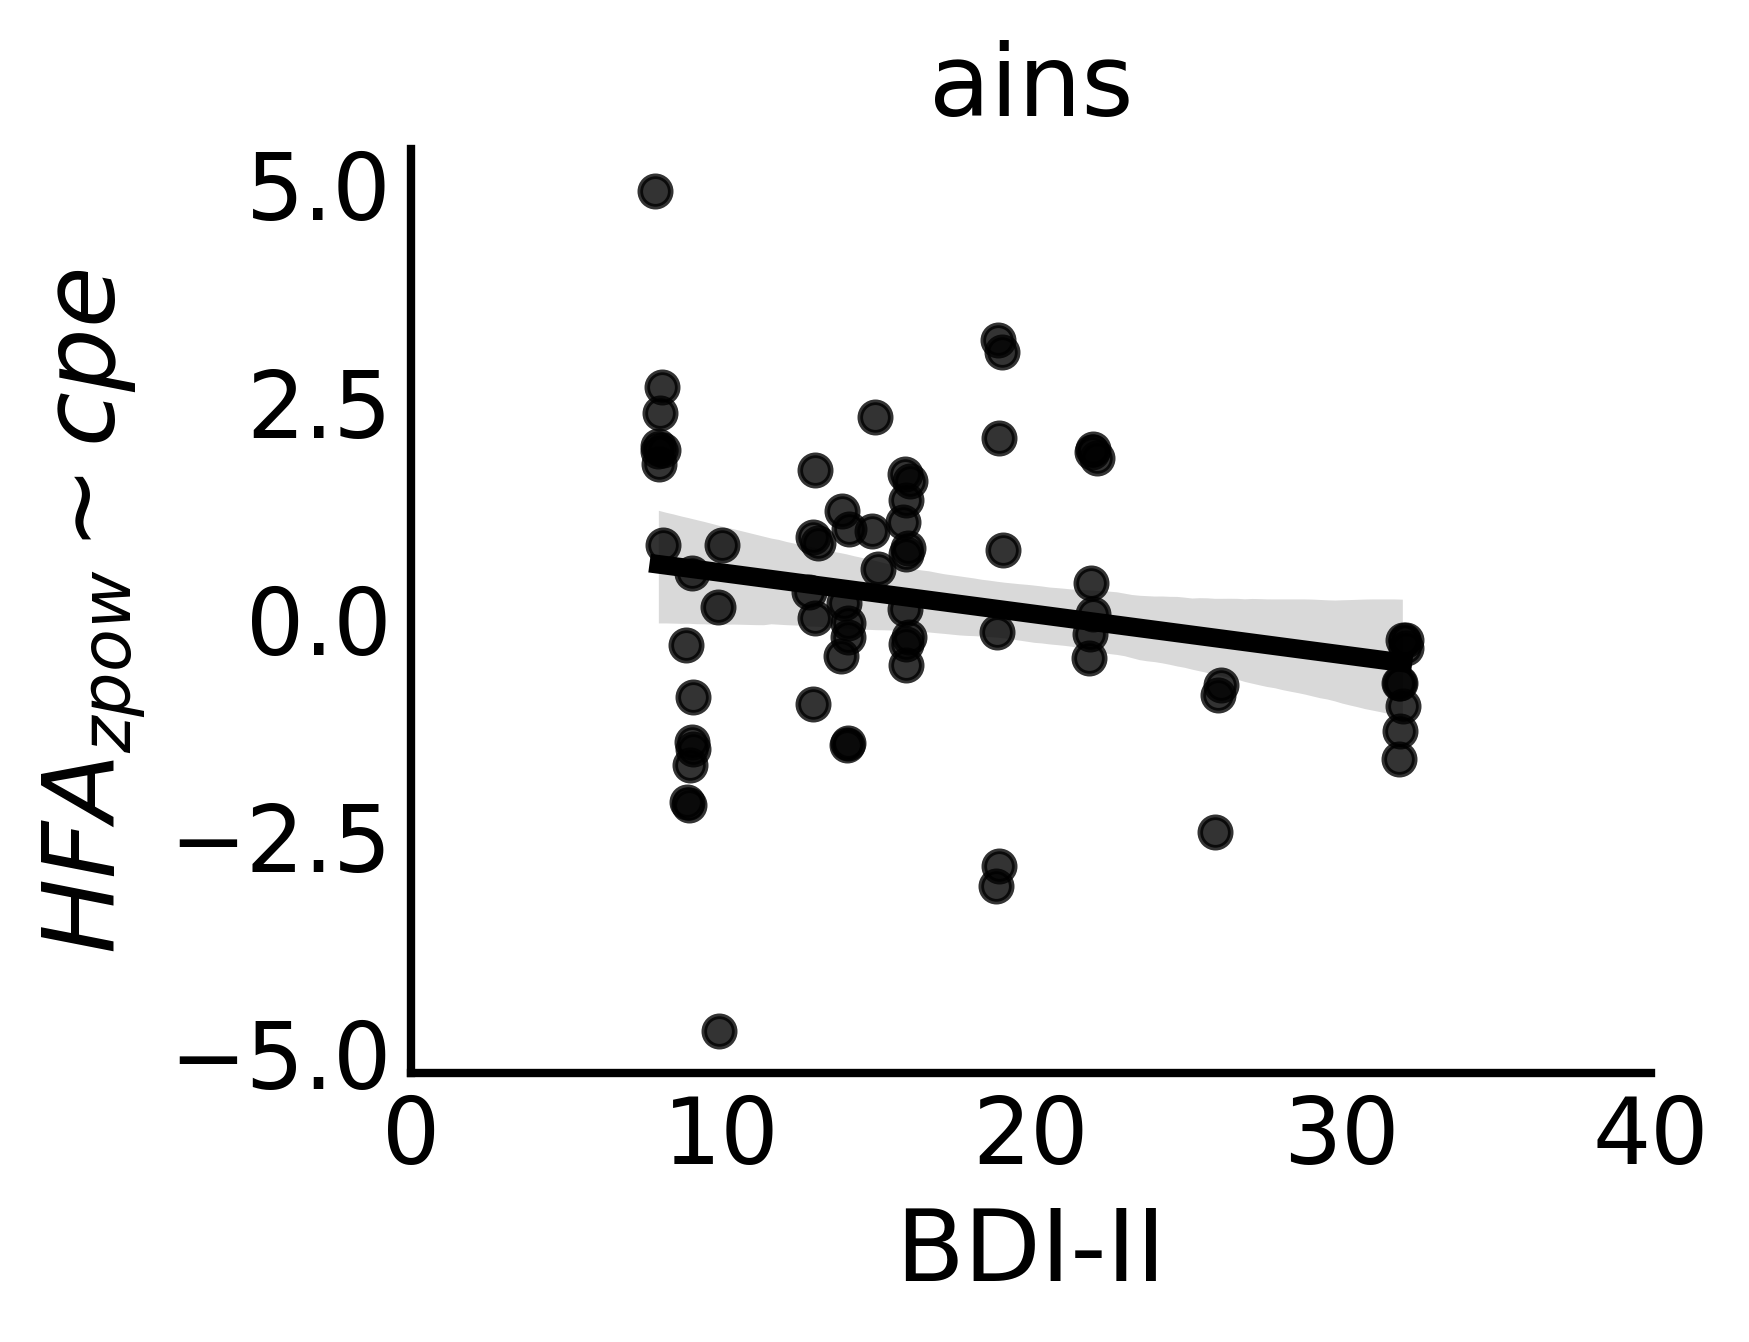

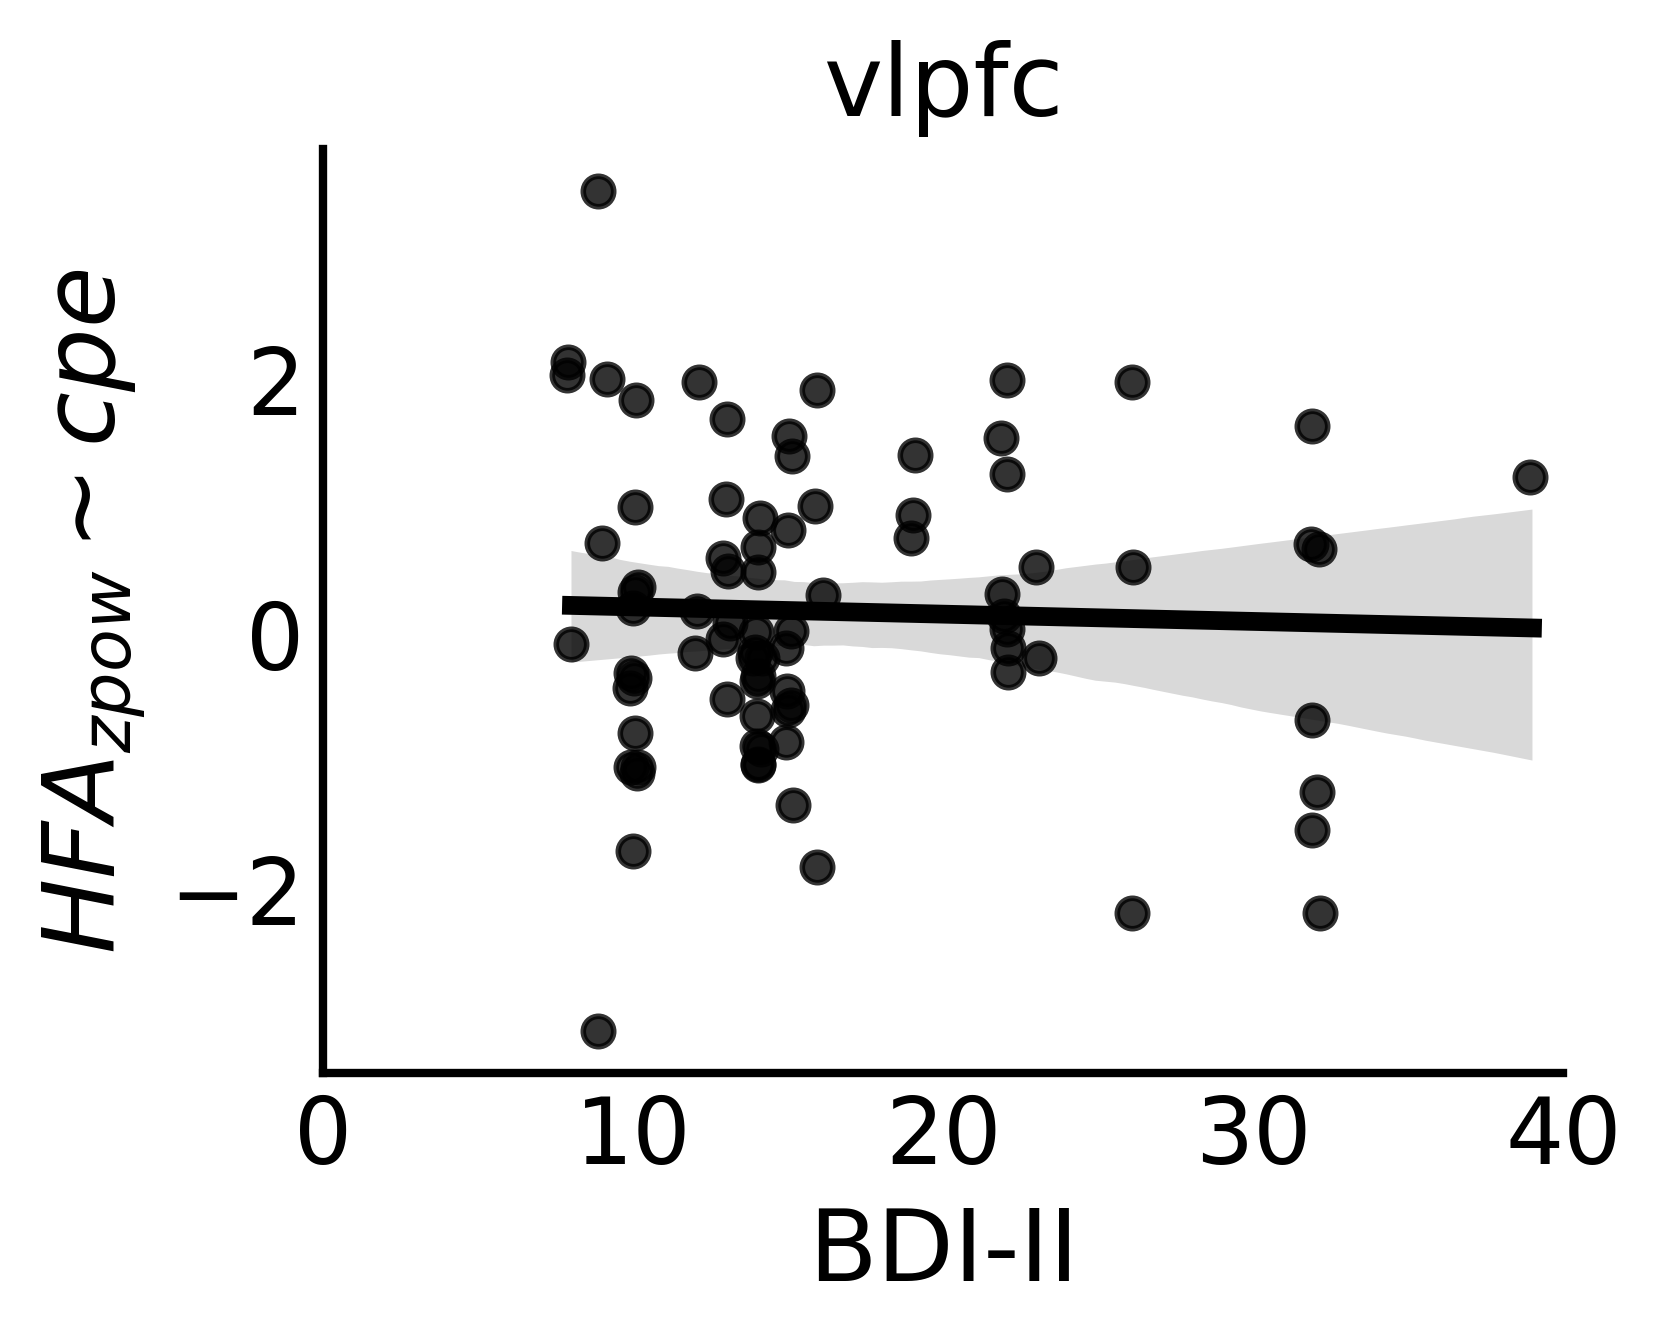

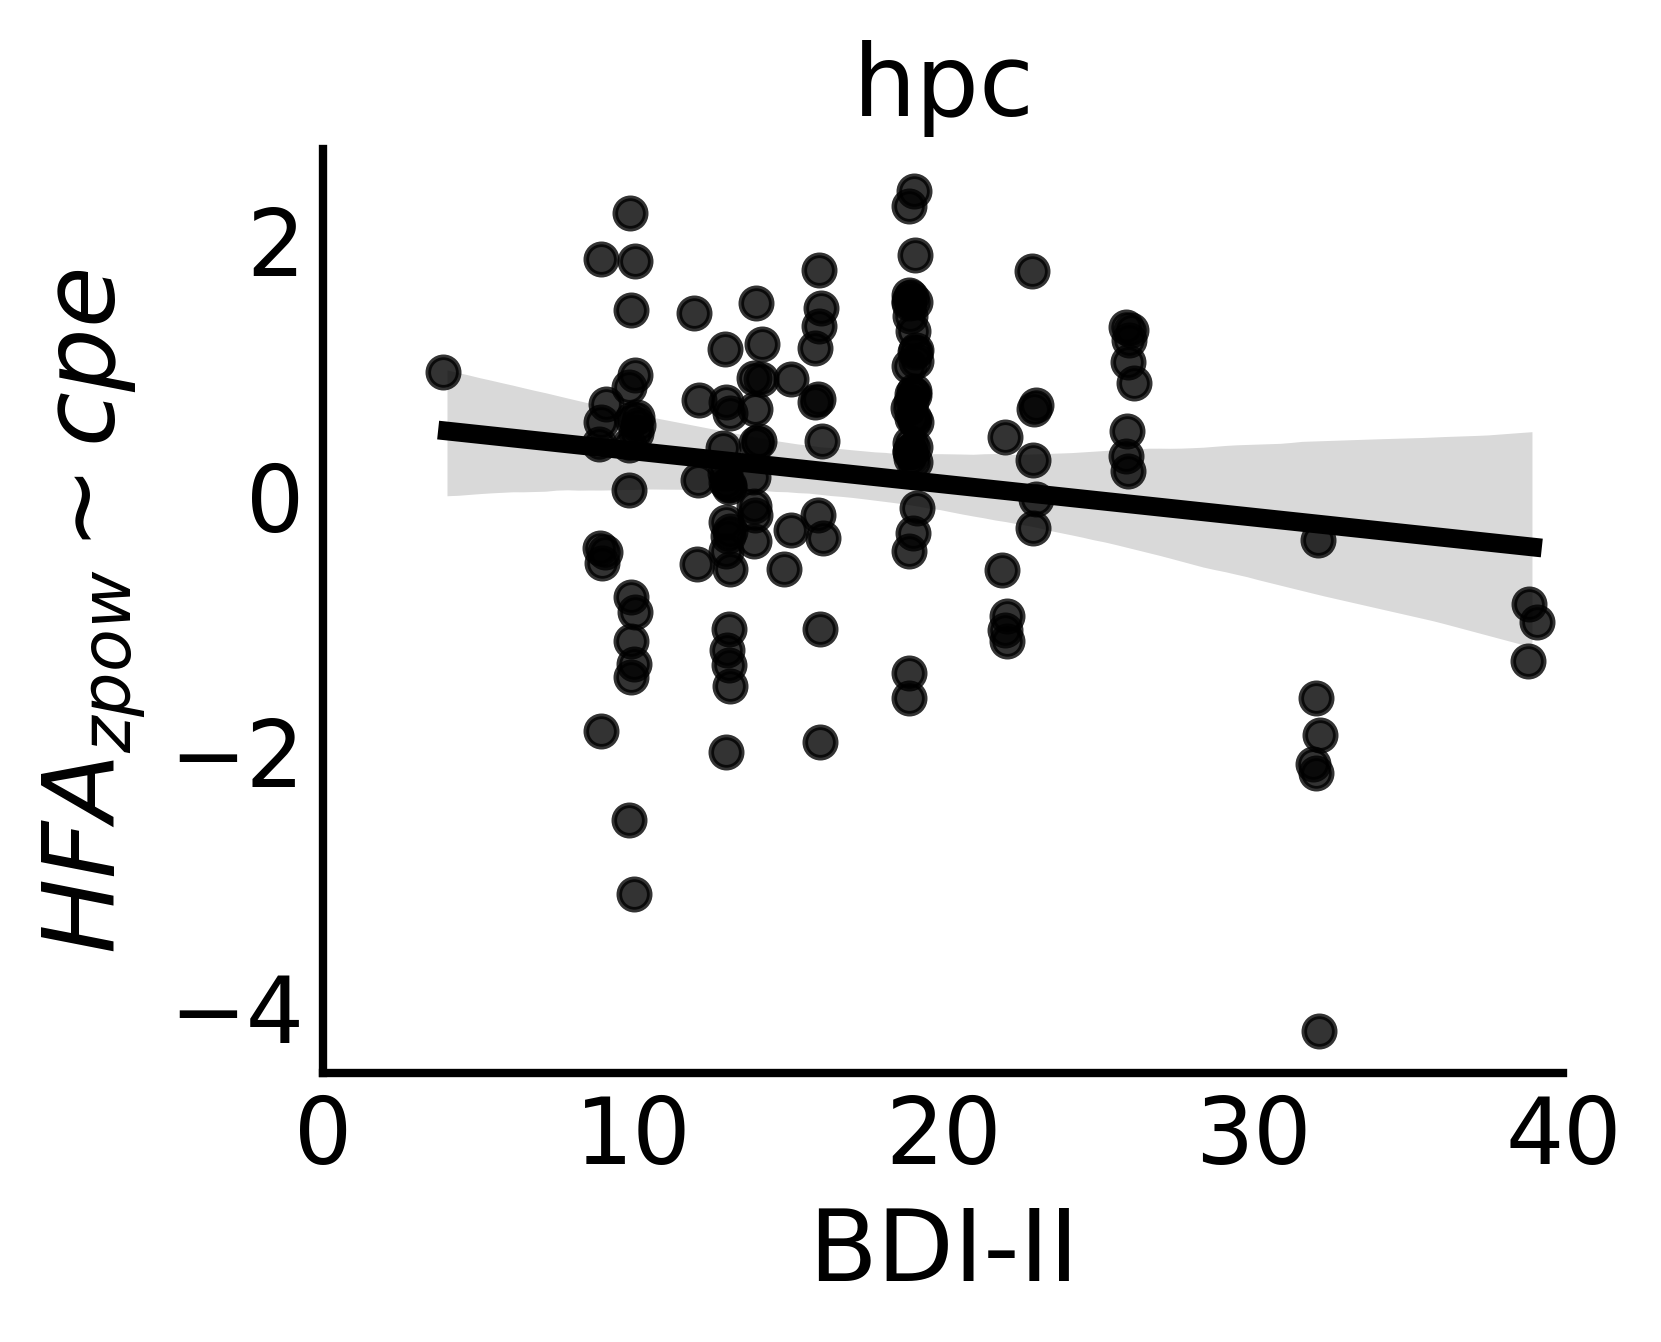

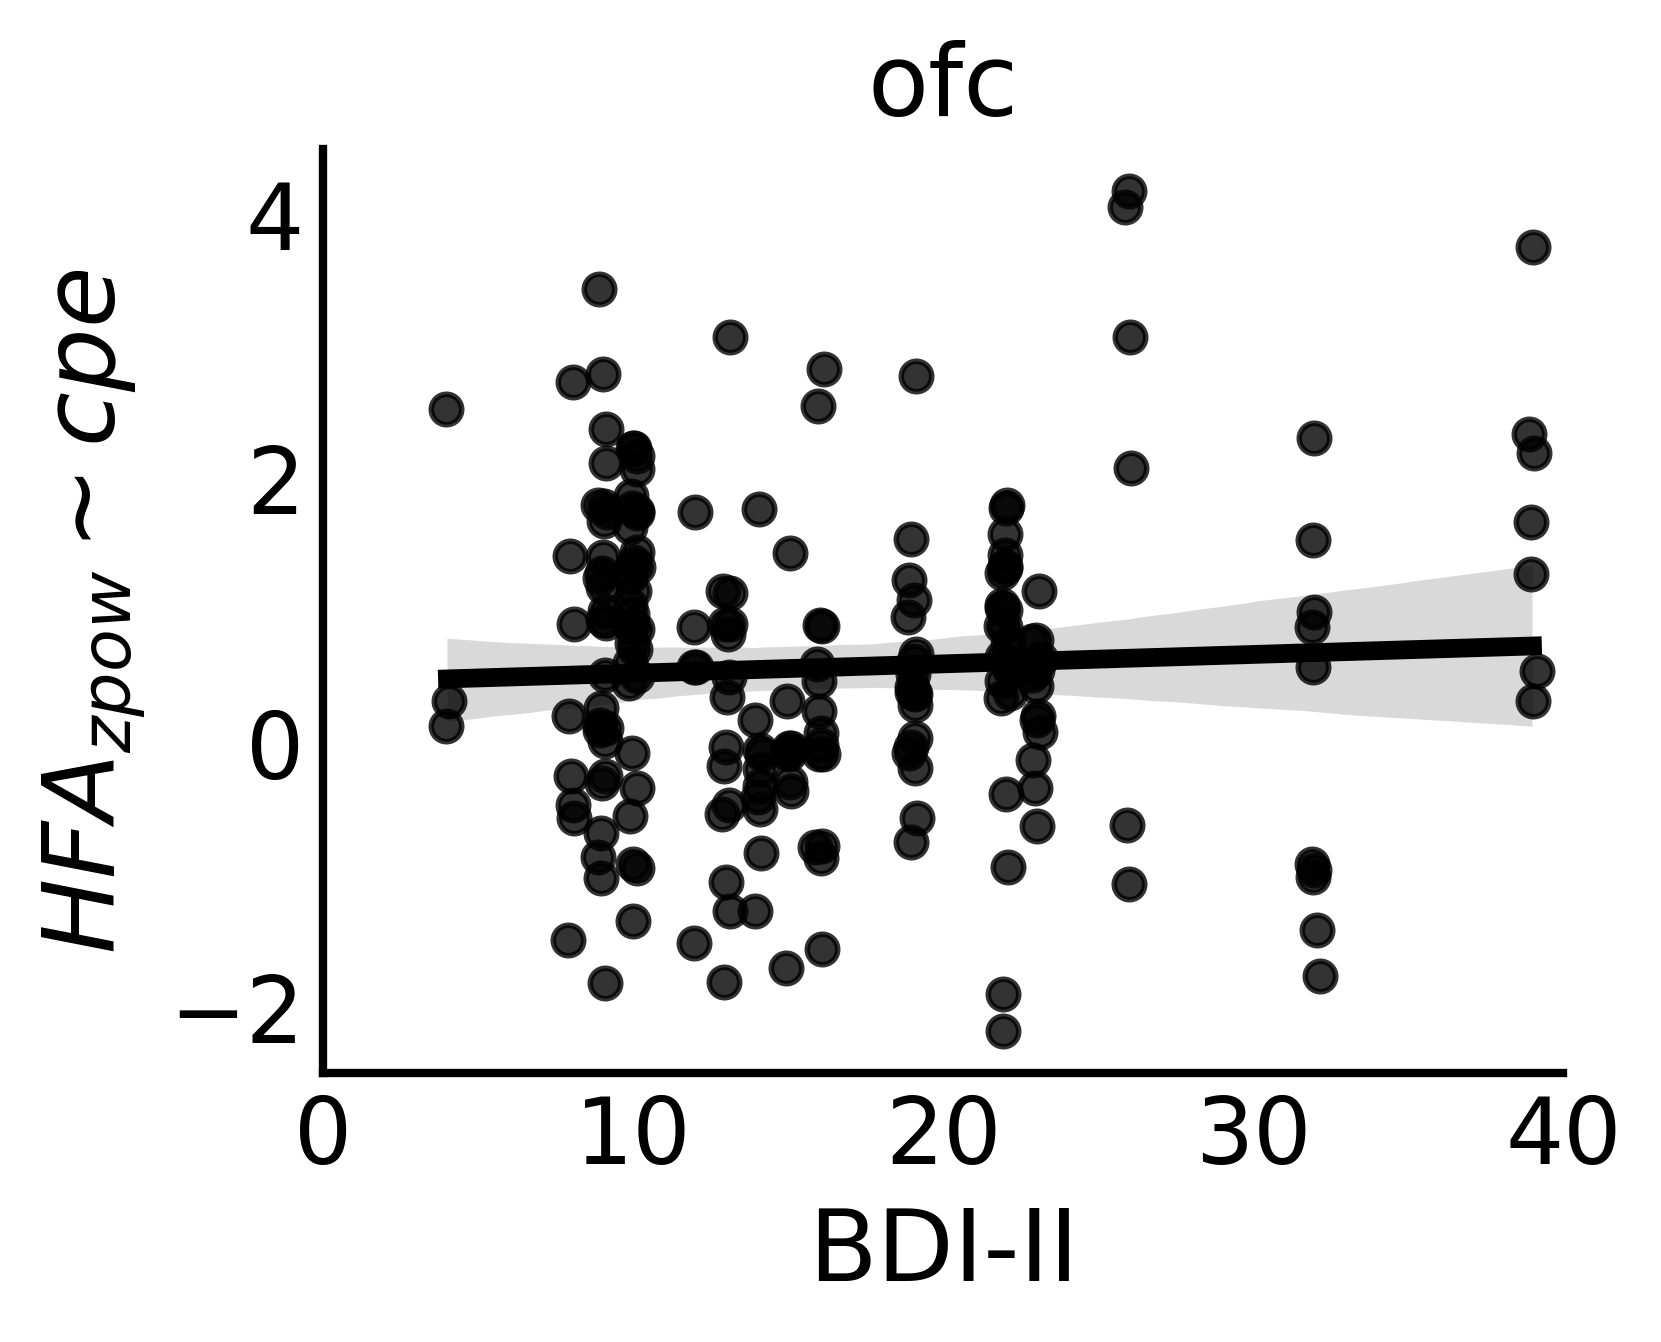

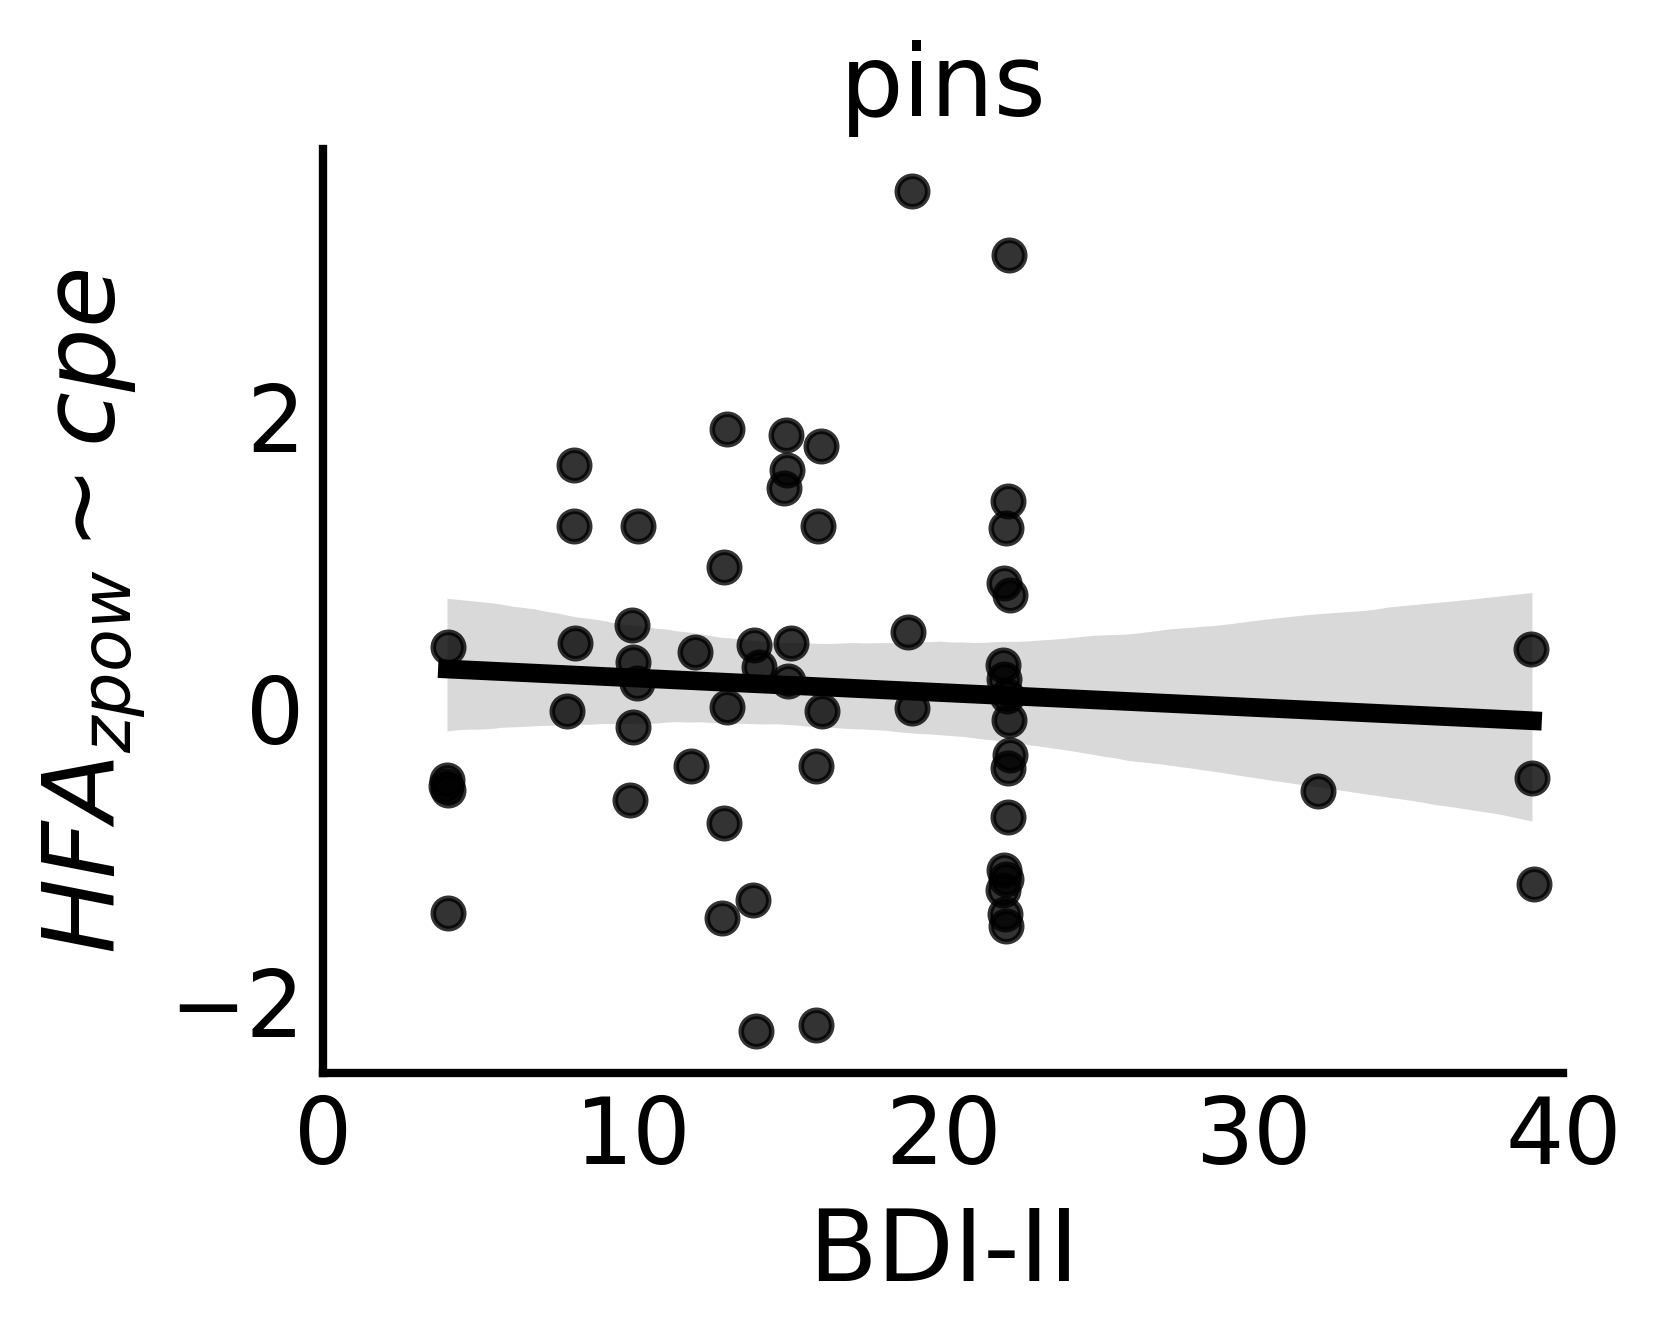

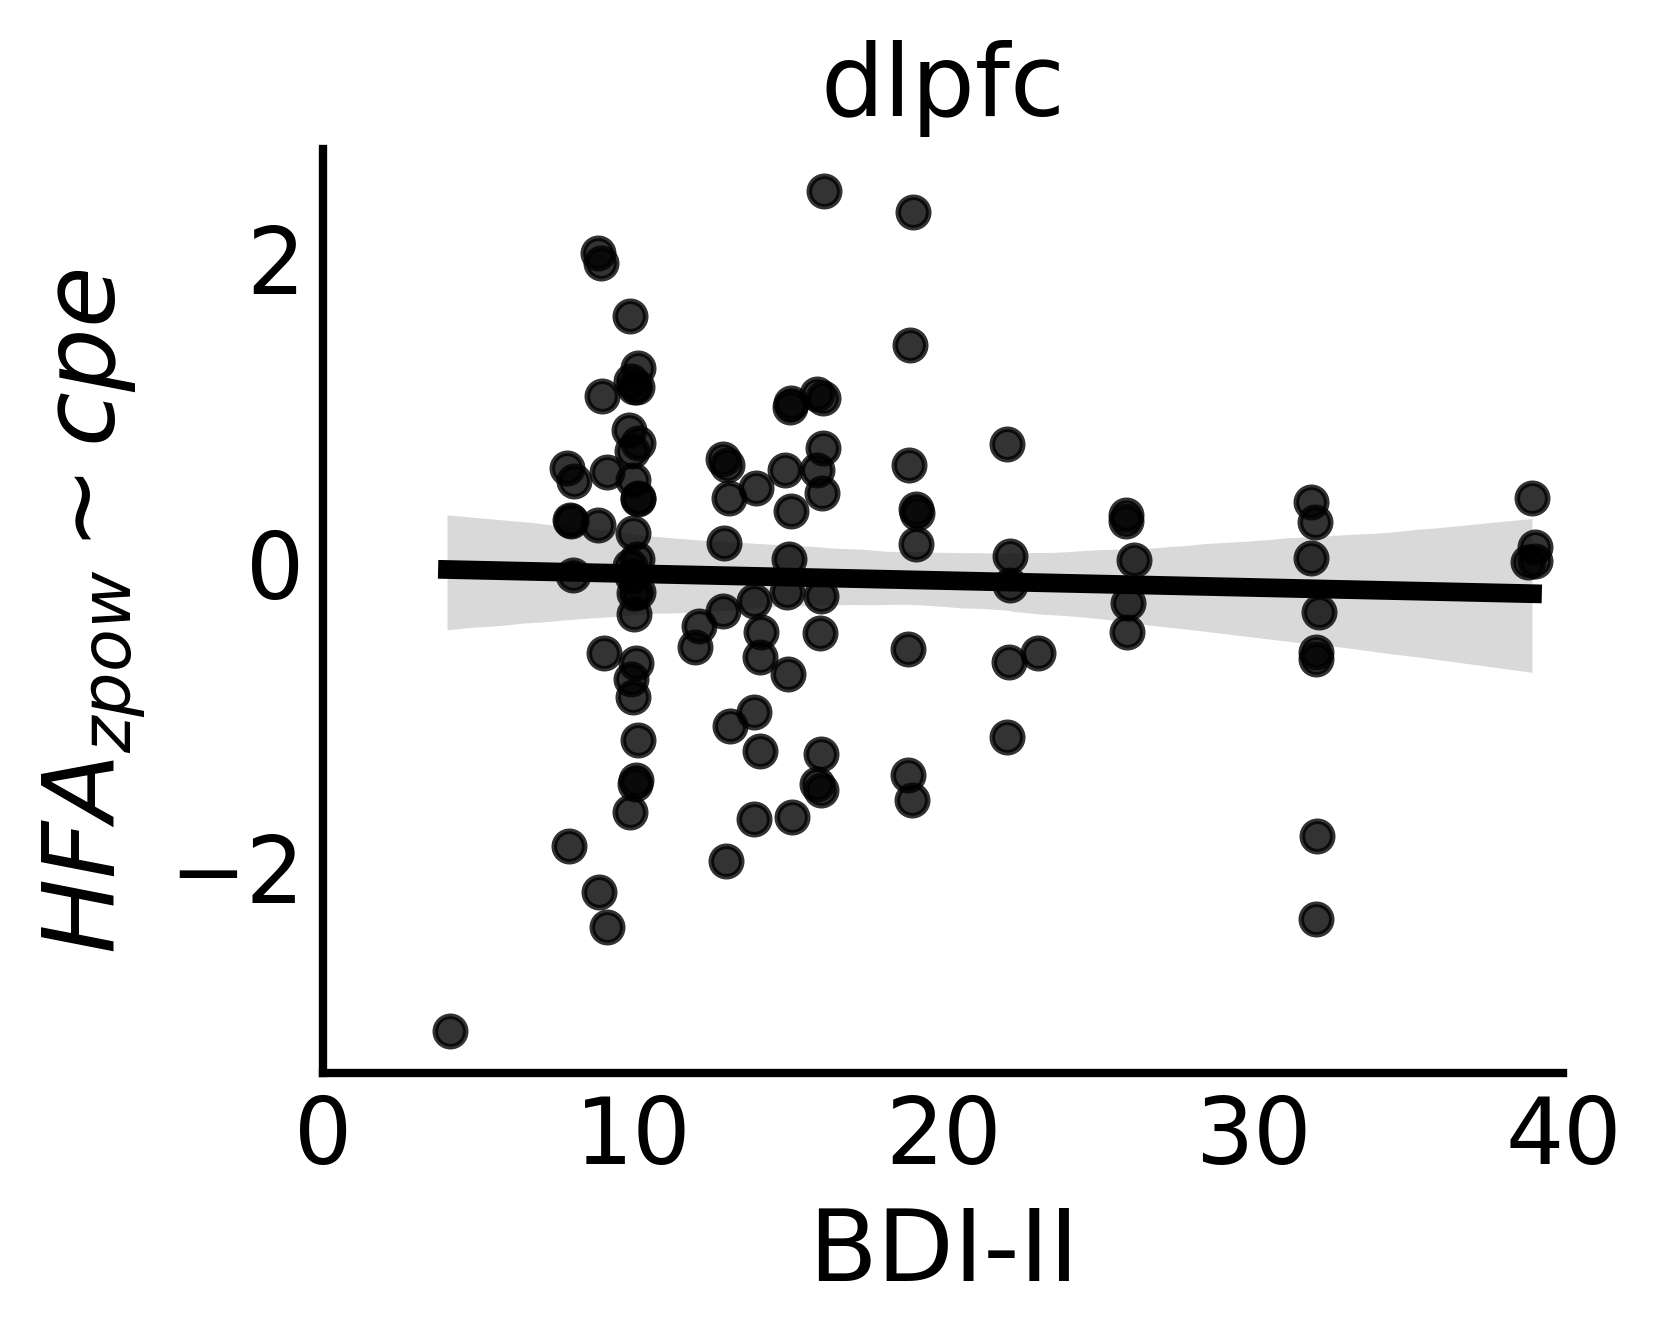

In [29]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'$HFA_{{zpow}} \sim cpe$')
    
    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [30]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_decisionCPE.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 22 Aug 2024                                         
Time:                        17:21:22                                         
No. Iterations:                    11                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.1402      0.473     34.128     

# Mixed effects models

In [35]:
reg_df = hfa_df.copy()
reg_df = reg_df[reg_df.roi.isin(bar_order)]
reg_df


,Unnamed: 0,subj_id,bdi,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,...,SafeBet,GambleChoice,GambleChoice_t1,TrialEV,Profit,TotalProfit,RPE,decisionCPE,decisionRegret,decisionRelief
0,0,MS002,14,lacas1-lacas2,MS002_lacas1-lacas2,0,118.986976,hfa,-0.015832,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
1,1,MS002,14,lacas2-lacas3,MS002_lacas2-lacas3,0,118.986976,hfa,-0.053265,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
2,2,MS002,14,lacas3-lacas4,MS002_lacas3-lacas4,0,118.986976,hfa,-0.019960,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
3,3,MS002,14,lacas4-lacas5,MS002_lacas4-lacas5,0,118.986976,hfa,-0.061600,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
4,4,MS002,14,lacas5-lacas6,MS002_lacas5-lacas6,0,118.986976,hfa,-0.195597,acc,...,-0.007878,safe,gamble,-0.437011,-0.032900,-1.028523,-0.008746,-0.395746,-0.287638,-0.392122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258455,258455,DA039,22,rpins1-rpins2,DA039_rpins1-rpins2,148,118.986976,hfa,-0.164942,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258456,258456,DA039,22,rpins2-rpins3,DA039_rpins2-rpins3,148,118.986976,hfa,-0.115631,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258457,258457,DA039,22,rpins3-rpins4,DA039_rpins3-rpins4,148,118.986976,hfa,-0.193613,pins,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244
258470,258470,DA039,22,rsgcc6-rsgcc7,DA039_rsgcc6-rsgcc7,148,118.986976,hfa,-0.162934,vlpfc,...,-0.047267,safe,gamble,-0.359505,-0.042732,0.993053,0.022985,-0.272392,-0.115665,-0.334244


In [36]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'decisionCPE','roi','hemi','bdi','bdi:decisionCPE']
rand_vars    = ['GambleChoice','TotalProfit', 'decisionCPE']


In [37]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [38]:
roi_fit_results['band'] = 'hfa'
# roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [40]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [41]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

['acc', 'amy']

In [42]:
sig_cpe_bdi_rois = fe_results.roi[fe_results.cpe_bdi_pval <= bonferr_alpha].tolist()
sig_cpe_bdi_rois

['amy']

In [39]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]
fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],hemi[T.r],TotalProfit,decisionCPE,bdi,bdi:decisionCPE,roi,cpe_pval,bdi_pval,cpe_bdi_pval
0,-0.001170,-0.006725,0.003880,-0.016278,0.011847,-0.000211,-0.000353,acc,0.0004,0.1798,0.0604
1,-0.012823,0.003165,0.009863,-0.016015,0.005782,0.000083,-0.000282,dmpfc,0.0804,0.7410,0.1177
2,-0.011194,0.004100,-0.003365,0.004985,0.018018,-0.000703,-0.000786,amy,0.0001,0.1369,0.0024
3,0.010936,0.000427,0.011294,0.001492,0.013960,-0.000753,-0.000628,ains,0.0535,0.1488,0.1184
4,-0.015014,0.008152,-0.001037,-0.012118,0.006527,0.000544,-0.000196,vlpfc,0.3438,0.3994,0.6144
5,-0.118569,0.006704,-0.017159,0.000568,0.013542,0.003443,-0.000727,hpc,0.0083,0.0135,0.0092
6,0.004837,0.013501,-0.014745,-0.011378,0.009104,-0.001022,0.000083,ofc,0.0217,0.0655,0.7014
7,-0.072810,-0.001643,0.047446,0.008999,0.005200,-0.000439,-0.000261,pins,0.4858,0.8350,0.5236
8,-0.003768,0.016253,-0.006951,-0.011643,-0.000470,-0.000479,0.000116,dlpfc,0.9364,0.2963,0.7108


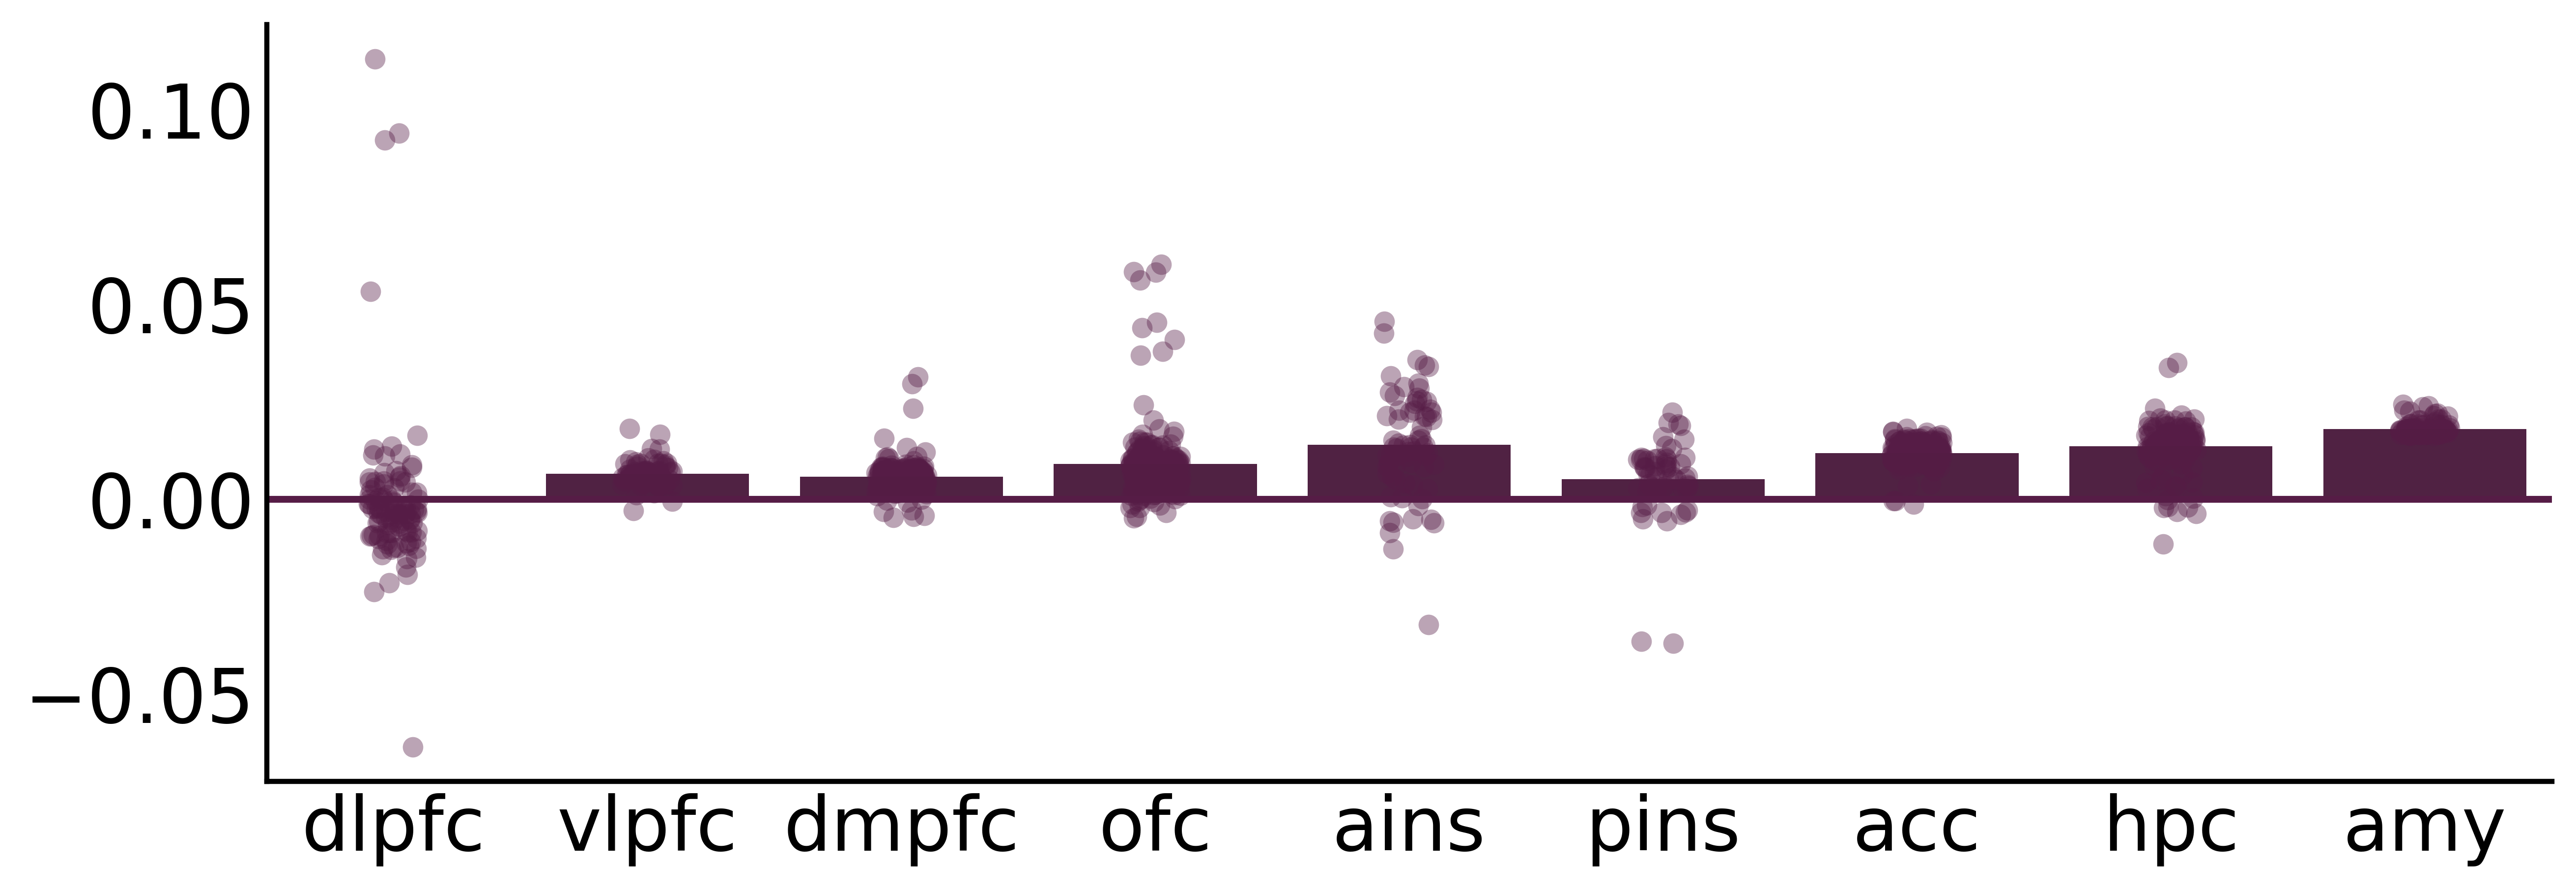

In [43]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=bar_order,figsize=(12,4),color='#561C46')


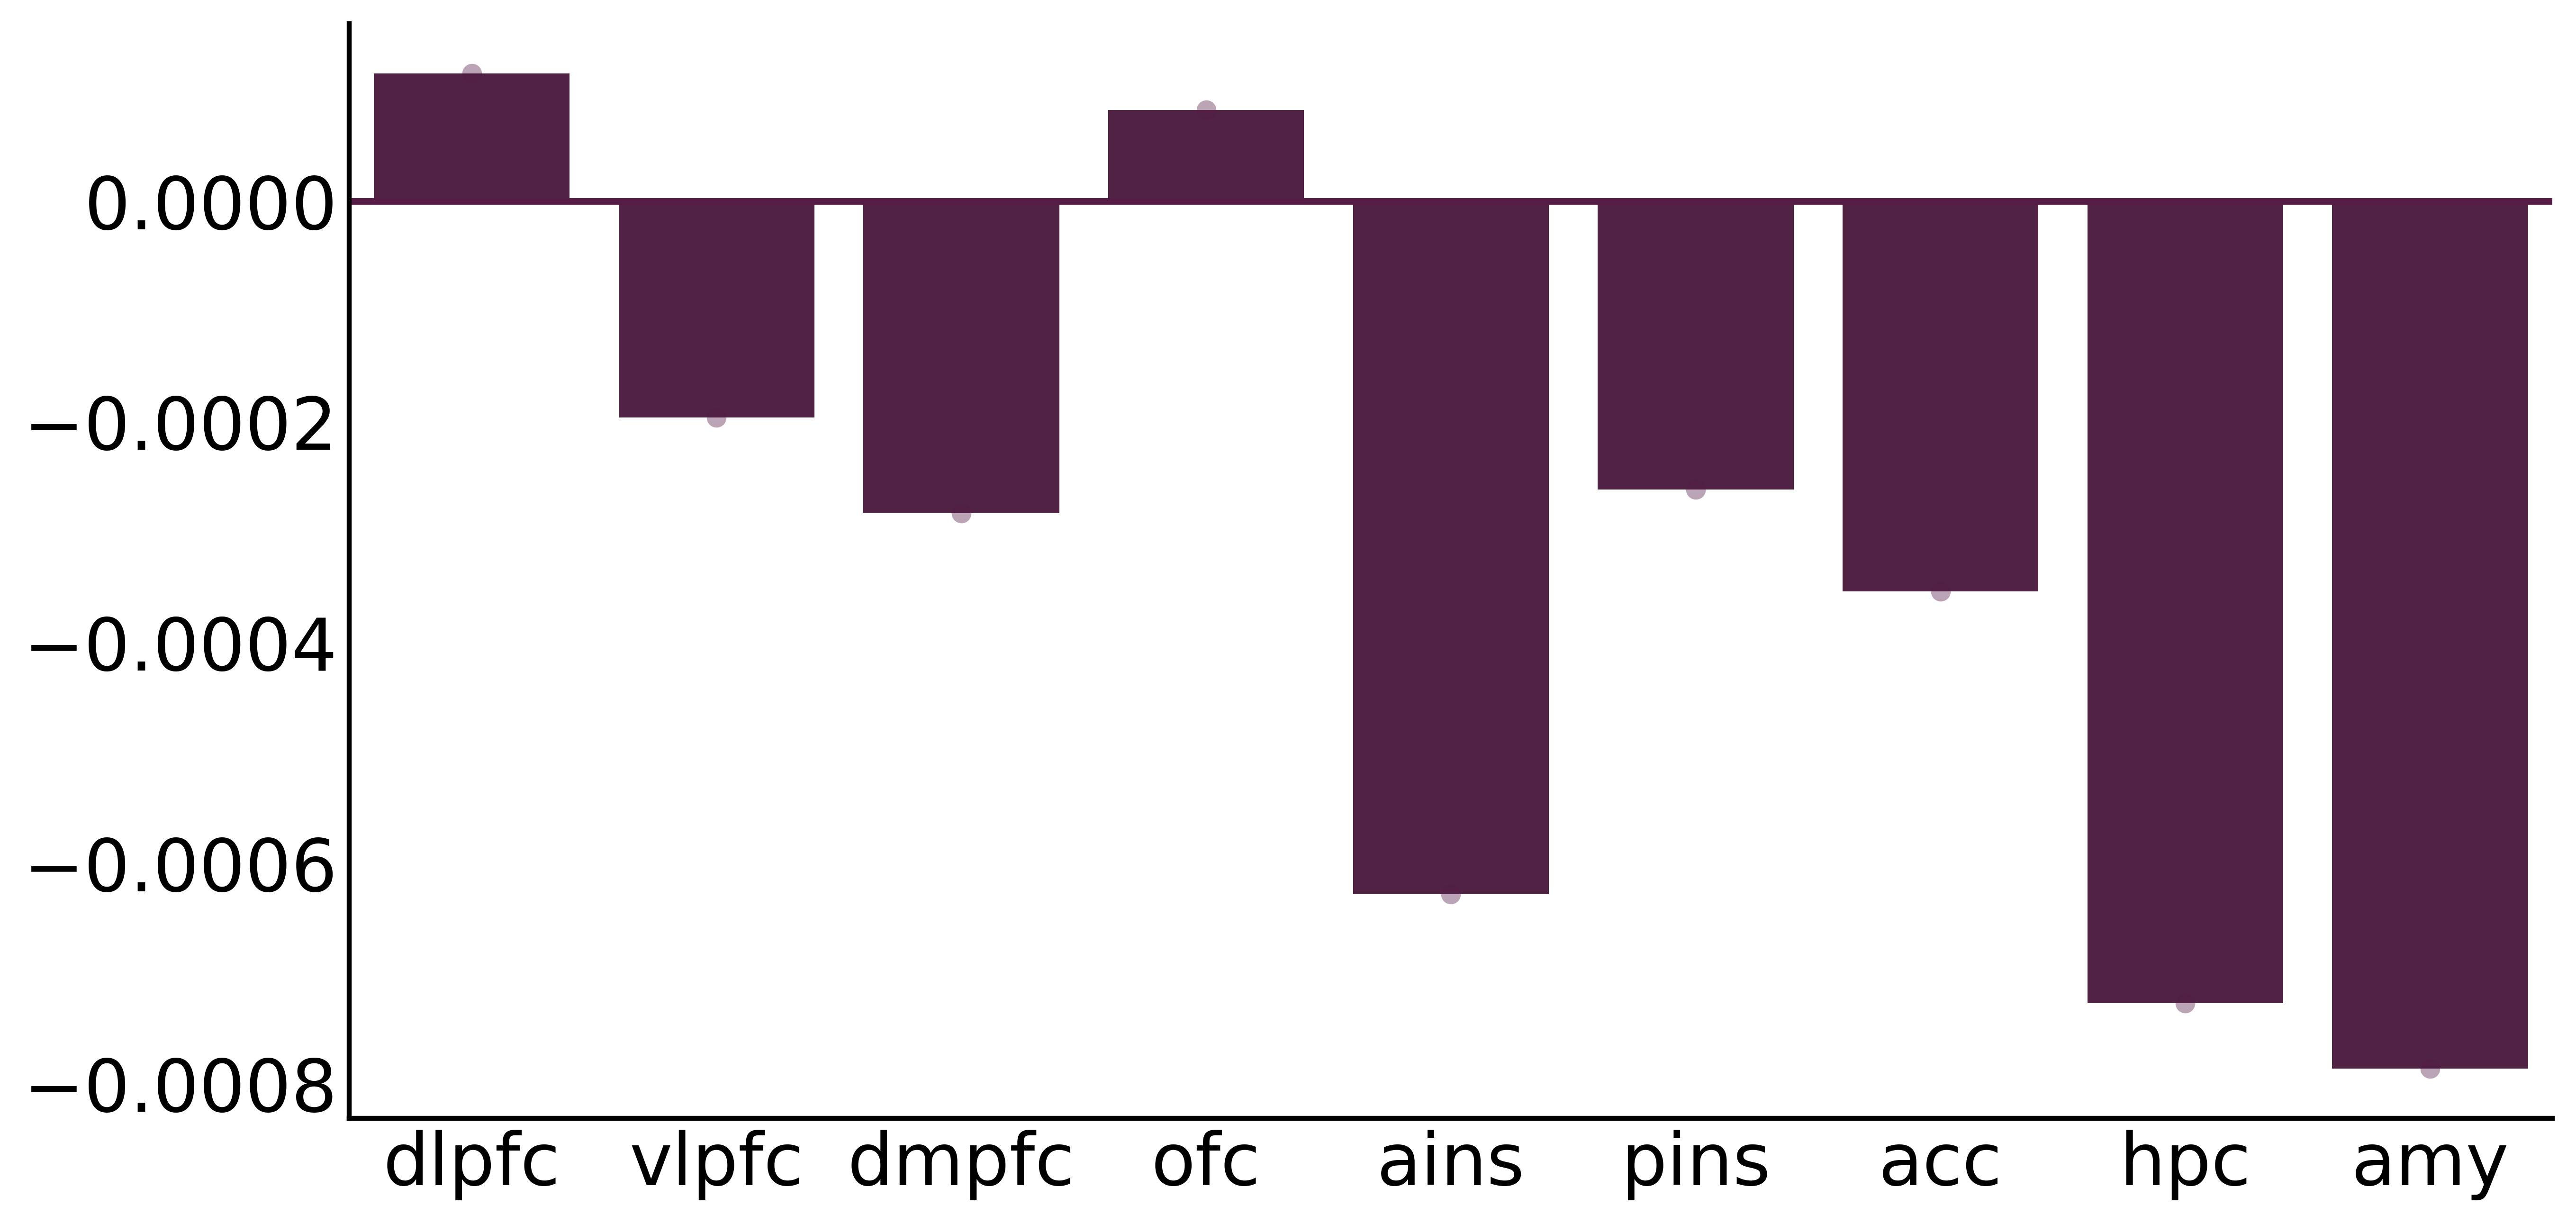

In [44]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#561C46')
# add to slides 
